In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from etl.nyc_311_api import NYC311RequestAPI
from etl.db import NYC311Database
from etl import utils
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy.stats import zscore
from eda import classification_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import numpy as np
import warnings
warnings.filterwarnings("ignore")


pio.renderers.default = "notebook_connected"

<h5 style="border: 2px solid #333; padding: 8px; display: inline-block;color:red">Note: the markdown file (filename) contains further explanations of the implementation choices</h5>

<h1 style="background-color:#d1cfcf;padding-top:20px;padding-bottom:20px;padding-left:5px">Data processing</h1>

### 1. Request data from API
- The class `NYC311RequestAPI` contains methods which makes calls to the 311 API
- To save time in running this analysis, historical data has already been saved to parquets paritioned by borough
- The method `get_and_save_data()` is defaulted to request only the latest data which is not already stored by the time this notebook is run
- The previous method sends 1 synchronous request to the 311 API and limits each request to 50,000 rows to avoid throttling
- The class takes an optional API token (hardcoded since this is a public API) which improves runtime by preventing throttling
- If setting the parameter `query_latest_data` to `False` in `get_and_save_data()`, the previous step will delete the existing folder and re-request all existing data (not recommended).

In [4]:
api_client = NYC311RequestAPI(url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json", api_token="Z3AKbMSPWFSZ38u17DoOwsVQT")

In [5]:
api_client.get_and_save_data(query_latest_data=True)

Creating DB connection to check latest data


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Requesting all data since 2025-10-04T02:46:48.000 unil 2025-10-06T11:13:56.363
Parquet #1 saved to /Users/emmadh/test/hbc_tech_assessment/data/311_requests (9724 rows)
No data returned for chunk #2
Data querying finished


### 

### 2. Build DuckDB with request data
- The class `NYC311Database` creates the databse at initialization and allows for refreshing. It contains methods for inspecting and cleaning the data as well as returning queries as a data frame (`query_data_as_df`)
- After initializing the database called <b>nyc311</b>, the resulting queries are more efficient

In [7]:
requests_db = NYC311Database()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### 

<h1 style="background-color:#d1cfcf;padding-top:20px;padding-bottom:20px;padding-left:5px">EDA - cleaning</h1>

### 1. Initial data examination
- This section runs some simple sanity checks to ensure the data has been refreshed and requested properly. Examples:
  - No duplicate unique request IDs + dates
  - Maximum date is equal to current date of notebook run
  - Minimum date is October 2010 (date of creation as stated <a href="https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data">here</a>)
  - All 5 boroughs existing in db
<b>GOAL:</b> get an initial understanding of the available data and potential issues needing to be cleaned

<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Minimum and maximum dates in database </b>
- These dates are as we'd expect

In [8]:
min_max_dates = requests_db.query_data_as_df("SELECT MAX(created_date) as max_created_date, MIN(created_date) as min_created_date from nyc311")
min_max_dates

,max_created_date,min_created_date
0,2025-10-05T02:56:15.000,2010-01-01T00:03:46.000


<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Columns and their initial data types </b>
- All datatypes are defaulted as strings (varchar) so these will be appropriately transformed in the following steps

In [9]:
columns_and_types = requests_db.query_data_as_df("DESCRIBE nyc311")
columns_and_types

,column_name,column_type,null,key,default,extra
0,unique_key,VARCHAR,YES,None,None,None
1,created_date,VARCHAR,YES,None,None,None
2,closed_date,VARCHAR,YES,None,None,None
3,agency,VARCHAR,YES,None,None,None
4,agency_name,VARCHAR,YES,None,None,None
5,complaint_type,VARCHAR,YES,None,None,None
6,descriptor,VARCHAR,YES,None,None,None
7,location_type,VARCHAR,YES,None,None,None
8,incident_zip,VARCHAR,YES,None,None,None
9,incident_address,VARCHAR,YES,None,None,None


<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Overall count of records </b>
- There are > 40,000,000 records with 40 columns
- This is a significant data size and will require the data to be sliced intentionally in the analysis

In [10]:
row_count = requests_db.query_data_as_df("SELECT COUNT(*) as row_count FROM nyc311")
row_count

,row_count
0,41304495


<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Percentage of null values per column  </b>
- The columns with the highest % of null values don't appear to be immediately useful or necessary for this report (bridge data, landmarks, street intersection)
- There are no missing values (at first glance) for borough, unique_key, complaint_type, or agency which are signficiant in determining where to allocate resources 
- There is a moderate amount (5-10%) of missing granular location data like latitude/longitude, zip code, address, location type which will be useful in prediction. The data cleaning step will dive further into these missing values
- In further steps, I will also assess the accuracy of the non-null data

In [11]:
data_columns = columns_and_types['column_name'].tolist()
total_row_count = row_count.iloc[0].item()

null_pct = {}
for col in data_columns:
    col_nulls = requests_db.query_data_as_df("SELECT COUNT(*) as count_nulls FROM nyc311 WHERE {} IS NULL".format(col))
    null_pct[col] = (col_nulls['count_nulls'].iloc[0].item() / total_row_count) * 100

pct_null_values_df = pd.DataFrame().from_records(null_pct, index=['percentage_null_values']).T.round(2).sort_values(by='percentage_null_values', ascending=False)
pct_null_values_df

,percentage_null_values
taxi_company_borough,99.93
road_ramp,99.77
bridge_highway_direction,99.72
bridge_highway_name,99.58
bridge_highway_segment,99.57
vehicle_type,99.24
taxi_pick_up_location,99.18
due_date,78.86
landmark,72.50
intersection_street_1,60.99


<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Duplicate unique keys </b>
- There are >96,000 duplicate unique keys, so these will be removed

In [12]:
count_duplicates = requests_db.query_data_as_df('''
WITH key_count AS (
    SELECT unique_key, COUNT(*) as unique_key_count FROM nyc311
    GROUP BY unique_key
)
SELECT COUNT(*) as count_duplicate_keys from key_count
WHERE unique_key_count > 1
''')
count_duplicates

,count_duplicate_keys
0,96975


<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Borough values </b>
- The borough datapoint is the minimum granularity needed for classification of resources
- For the 5 boroughs (Bronx, Brooklyn, Queens, Staten Island, Manhattan), there are no values needing standardization
- The hive default partition indicates there was no borough when saving the parquet
- The Unspecified borough indicates this was directly entered in the data
- In both of the previous cases, we will need to replace these values using other location data

In [13]:
borough_counts = requests_db.query_data_as_df('''
    SELECT borough, COUNT(*) AS count_records FROM nyc311
    GROUP BY borough 
    ORDER BY count_records DESC
''')
borough_counts

,borough,count_records
0,BROOKLYN,12351747
1,QUEENS,9715993
2,MANHATTAN,8147163
3,BRONX,7862896
4,STATEN ISLAND,1956404
5,Unspecified,1270292


<b style="border-bottom: 2px solid #333; padding: 2px; display: inline-block;"> Complaint types </b>
- Complaint types are the core of this report, so it's important these values are standardized and accurate
- There are over 500 different complaint types, those with lower counts are obviously incorrect
- There are some complaints which are very similar in nature and could be grouped together (e.g. HEAT/HOT WATER and HEAT)

In [14]:
complaint_types_counts = requests_db.query_data_as_df('''
    SELECT complaint_type, COUNT(*) AS count_records FROM nyc311
    GROUP BY complaint_type 
    ORDER BY count_records DESC
''')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(complaint_types_counts)

,complaint_type,count_records
0,Noise - Residential,3952787
1,Illegal Parking,3258955
2,HEAT/HOT WATER,2528976
3,Blocked Driveway,1809809
4,Noise - Street/Sidewalk,1473562
5,Street Condition,1360672
6,Street Light Condition,1166442
7,Request Large Bulky Item Collection,1073728
8,PLUMBING,1034225
9,Water System,1001508


### 

### 2. Clean data
Based on some of the previous exploration, this section handles cleaning the nyc311 database

`alter_datatypes()`:
- String fields: trim whitespaces
- Numeric fields: convert to doubles
- Date fields: convert to timestamps

In [15]:
requests_db.alter_datatypes()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [16]:
columns_and_types = requests_db.query_data_as_df("DESCRIBE nyc311")
columns_and_types

,column_name,column_type,null,key,default,extra
0,unique_key,VARCHAR,YES,None,None,None
1,complaint_type,VARCHAR,YES,None,None,None
2,descriptor,VARCHAR,YES,None,None,None
3,borough,VARCHAR,YES,None,None,None
4,incident_zip,VARCHAR,YES,None,None,None
5,incident_address,VARCHAR,YES,None,None,None
6,created_date,TIMESTAMP,YES,None,None,None
7,closed_date,TIMESTAMP,YES,None,None,None
8,due_date,TIMESTAMP,YES,None,None,None
9,resolution_action_updated_date,TIMESTAMP,YES,None,None,None


Ensure there are no missing columns in the modified table: 

In [17]:
[i for i in data_columns if i not in columns_and_types.column_name.tolist()]

[]

`remove_unique_key_duplicates()`
- Identifies duplicate unique keys and keeps only the latest entry by created_date

In [18]:
requests_db.remove_unique_key_duplicates()

Validate that there are no duplicates remaining:

In [19]:
count_duplicates = requests_db.query_data_as_df('''
WITH key_count AS (
    SELECT unique_key, COUNT(*) as unique_key_count FROM nyc311
    GROUP BY unique_key
)
SELECT COUNT(*) as count_duplicate_keys from key_count
WHERE unique_key_count > 1
''')
count_duplicates

,count_duplicate_keys
0,0


`impute_missing_borough()` and `standardize_zip_codes()`
- First replace the default hive partition and Unspecified with Null
- Impute missing boroughs by matching on zip code. If there are two boroughs found, the value will not be imputed so to not improperly fill the data
- In order to impute the boroughs, the zip codes need to be standardized first as there are many non-numeric values and values which don't align with the proper format for NYC zipcodes (either 5 digits or XXXXX-XXXX) 

In [20]:
zips = requests_db.query_data_as_df('''
SELECT DISTINCT(incident_zip) 
FROM nyc311
ORDER BY incident_zip DESC;''')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(zips)

,incident_zip
0,na
1,`10708
2,ZIP CODE
3,XXXXXXXXXX
4,XXXXX
5,XXX
6,X
7,W1
8,VARIES
9,V6J4X9


In [21]:
requests_db.standardize_zip_codes()

In [22]:
zips = requests_db.query_data_as_df('''
SELECT DISTINCT(incident_zip) 
FROM nyc311
ORDER BY incident_zip DESC;''')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(zips)

,incident_zip
0,99999
1,99214
2,98335
3,98277
4,98230
5,98206
6,98188
7,98130
8,98124
9,98108


In [23]:
requests_db.update_values_to_null('borough',('__HIVE_DEFAULT_PARTITION__','UNSPECIFIED'))
requests_db.impute_missing_boroughs()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [24]:
requests_db.query_data_as_df('''
SELECT COUNT(*) * 100.0 / (SELECT COUNT(*) FROM nyc311) AS percent_null_borough_vals
FROM nyc311
WHERE borough IS NULL;''').round(2)

,percent_null_borough_vals
0,2.18


In [25]:
requests_db.drop_nulls('borough')

`standardize_complaint_types()`
- Use regex to remove values not a-z or A-Z
- Remove complaint types with counts in the bottom 25th percentile (gets rid of nonsensical complaints and complaints which are not significant enough to allocate resources)
- Group similar complaints together to get a more accurate view of counts later
  - I apply a clustering technique (agglomerative clustering) which groups the complaint_type values together
  - Ideally, a model would be trained on this specific data to have increased accuracy
  - The goal of this clustering is to simply reduce the amount of time needed to manually map similar types
  - Some remapping is needed for incorrect groupings
- The following code saves a yaml of the granular complaint types to their broader groups (in /config/config.yaml). This is used to create a new column in the database for the broader complaint groups

In [26]:
requests_db.standardize_complaint_column()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:
complaint_types_counts = requests_db.query_data_as_df('''
    SELECT complaint_type, COUNT(*) AS count_records FROM nyc311
    GROUP BY complaint_type 
    ORDER BY count_records DESC
''')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(complaint_types_counts)

,complaint_type,count_records
0,NOISE RESIDENTIAL,3949455
1,ILLEGAL PARKING,3253075
2,HEAT HOT WATER,2526544
3,BLOCKED DRIVEWAY,1807679
4,NOISE STREET SIDEWALK,1471625
5,STREET CONDITION,1359260
6,STREET LIGHT CONDITION,1151026
7,REQUEST LARGE BULKY ITEM COLLECTION,1073722
8,PLUMBING,1015028
9,UNSANITARY CONDITION,1004355


In [28]:
# get mapping dict, save to initial yaml, update groups and join to table
complaint_type_mapping_dict = utils.cluster_text_values(complaint_types_counts, 'complaint_type')
utils.save_yaml(complaint_type_mapping_dict, 'config/config.yaml', 'complaint_groups')
requests_db.group_complaint_types()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<b>Number of complaint types before and after grouping on complaints (only those with sufficient counts):</b>

In [29]:
requests_db.connection.execute('''
SELECT COUNT(DISTINCT(complaint_type)) as count_new_complaints, COUNT(DISTINCT(complaint_type_raw)) as count_raw_complaints
FROM nyc311
''').df()

,count_new_complaints,count_raw_complaints
0,120,268


<b>The following table and visualization demonstrates how some of the complaints are mapped</b>

In [30]:
mapped_complaints_final = requests_db.connection.execute('''
SELECT complaint_type, complaint_type_raw, count(complaint_type) as count_raw
FROM nyc311
group by complaint_type, complaint_type_raw
''').df()
mapped_complaints_final.sort_values(by='complaint_type', ascending=False).head(10)

,complaint_type,complaint_type_raw,count_raw
14,WATER MAINTENANCE,WATER SYSTEM,1000214
4,WATER MAINTENANCE,WATER QUALITY,22291
136,WATER MAINTENANCE,WATER LEAK,398202
187,WATER MAINTENANCE,WATER MAINTENANCE,400
242,WATER CONSERVATION,WATER CONSERVATION,60649
232,URINATING IN PUBLIC,URINATING IN PUBLIC,10987
75,UNSANITARY CONDITION,UNSANITARY CONDITION,1004355
121,UNSANITARY CONDITION,UNSANITARY PIGEON CONDITION,12877
212,UNLEASHED DOG,UNLEASHED DOG,15587
243,TRAFFIC,TRAFFIC,80550


In [31]:
avg_count_per_group = mapped_complaints_final.groupby('complaint_type').mean(numeric_only=True)
sufficient_counts = avg_count_per_group[avg_count_per_group.count_raw > avg_count_per_group.describe().loc['75%'].item()]

In [32]:
fig = px.treemap(
    mapped_complaints_final[mapped_complaints_final.complaint_type.isin(sufficient_counts.index)],
    path=['complaint_type', 'complaint_type_raw'],
    values='count_raw',
    title="NYC 311 Complaint Types Mapping"
)
fig

<h1 style="background-color:#d1cfcf;padding-top:20px;padding-bottom:20px;padding-left:5px">EDA - high level visualizations, patterns, features </h1>

- The below code adds year, month, and day to table
- Pulls the borough level population data from another NYC API (data.cityofnewyork.us/resource/ph5g-sr3v) and joins to the main table to get population level statistics

In [35]:
requests_db.add_granular_datequery_columns()
borough_population_df = utils.get_borough_population_data()
requests_db.create_table_from_df(borough_population_df, 'borough_population')

In [36]:
requests_db.join_with_population_data()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Top complaints across entire set
- The most complaints across all boroughs and years is by far <b>noise complaints</b>

In [37]:
top_complaints_total = requests_db.query_data_as_df('''
WITH complaint_counts AS (
    SELECT 
        complaint_type,
        COUNT(*) AS complaint_count
    FROM nyc311
    GROUP BY complaint_type
)
SELECT *
FROM complaint_counts
QUALIFY ROW_NUMBER() OVER (
    ORDER BY complaint_count DESC
) <= 5;


''')
top_complaints_total

,complaint_type,complaint_count
0,NOISE,7764709
1,ILLEGAL PARKING,3267122
2,HEAT HOT WATER,3265536
3,DEP STREET CONDITION,2511214
4,BLOCKED DRIVEWAY,1874859


### Top complaints by year
- The following table shows the top 2 complaints per year
- It's clear that noise is an issue regardless of year

In [38]:
top_complaints_by_year = requests_db.query_data_as_df('''
WITH complaint_counts AS (
    SELECT 
        complaint_type,
        year,
        COUNT(*) AS complaint_count
    FROM nyc311
    GROUP BY complaint_type, year
)
SELECT *
FROM complaint_counts
QUALIFY ROW_NUMBER() OVER (
    PARTITION BY year
    ORDER BY complaint_count DESC
) <= 2
ORDER BY year, complaint_count DESC;
''')
top_complaints_by_year

,complaint_type,year,complaint_count
0,DEP STREET CONDITION,2010,217781
1,NOISE,2010,202206
2,DEP STREET CONDITION,2011,204448
3,NOISE,2011,204198
4,NOISE,2012,229445
5,HEAT HOT WATER,2012,183948
6,NOISE,2013,259628
7,HEAT HOT WATER,2013,204304
8,NOISE,2014,337983
9,HEAT HOT WATER,2014,231930


### Proportion of total complaints by borough 
- In order to identify which location has the most complaints, we need to examine per capita/per resident complaints
- This following query takes the total complaints in the dataset and divides by borough level populatin data
- Although Manhattan has more complaints in pure count, the Bronx has more complaints per resident
- Due to this, the Bronx is chosen as the borough to focus on in terms of allocating resources

In [39]:
prop_total_by_borough = requests_db.get_total_calls_by_borough()
prop_total_by_borough

,borough,complaint_count,average_population,complaints_per_capita
0,BRONX,7957869,1482534.75,5.367745
1,BROOKLYN,12440388,2698974.25,4.609302
2,MANHATTAN,8182624,1648122.75,4.964815
3,QUEENS,9757970,2341624.25,4.167180
4,STATEN ISLAND,1968915,488685.75,4.029000


### Examine boroughs with top complaints
- This following query and visualizations looks at the top 2 complaints per borough
- Again noise is a consistent issue regardless of borough
- Slicing the data in different ways comes to the same conclusion that noise is a significant issue which should be focused on

In [40]:
top_comaplaints_by_borough = requests_db.get_top_complaint_by_borogh()
top_comaplaints_by_borough

,borough,complaint_type,complaint_count,average_population,complaints_per_capita
0,BRONX,NOISE,1895268,1482534.75,1.278397
1,BRONX,HEAT HOT WATER,1101633,1482534.75,0.743074
2,BROOKLYN,NOISE,2058177,2698974.25,0.762577
3,BROOKLYN,ILLEGAL PARKING,1207752,2698974.25,0.447486
4,MANHATTAN,NOISE,2197111,1648122.75,1.333099
5,MANHATTAN,HEAT HOT WATER,738323,1648122.75,0.447978
6,QUEENS,NOISE,1430210,2341624.25,0.610777
7,QUEENS,ILLEGAL PARKING,1000396,2341624.25,0.427223
8,STATEN ISLAND,DEP STREET CONDITION,243929,488685.75,0.499153
9,STATEN ISLAND,NOISE,183943,488685.75,0.376403


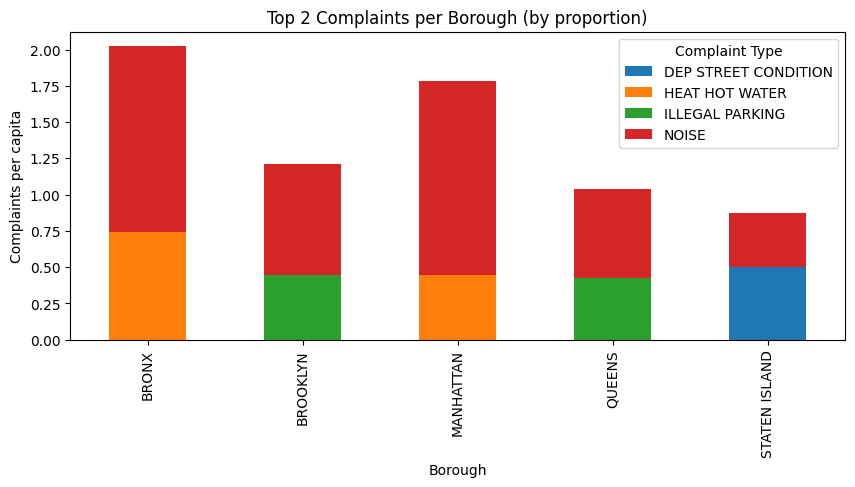

In [41]:
pivot = top_comaplaints_by_borough.pivot(index="borough", columns="complaint_type", values="complaints_per_capita")
pivot.plot(kind="bar", stacked=True, figsize=(10,4))

plt.title("Top 2 Complaints per Borough (by proportion)")
plt.ylabel("Complaints per capita")
plt.xlabel("Borough")
plt.legend(title="Complaint Type")
plt.show()

### Proportion complaints by year + borough
- The next two visualizations demonstrates how 311 calls have been changing over time (as a per capita measurement)
- With the exceptin of Staten Island, 311 calls have been increasing over the last few years
- The Bronx in particular has seen an uptick in recent years

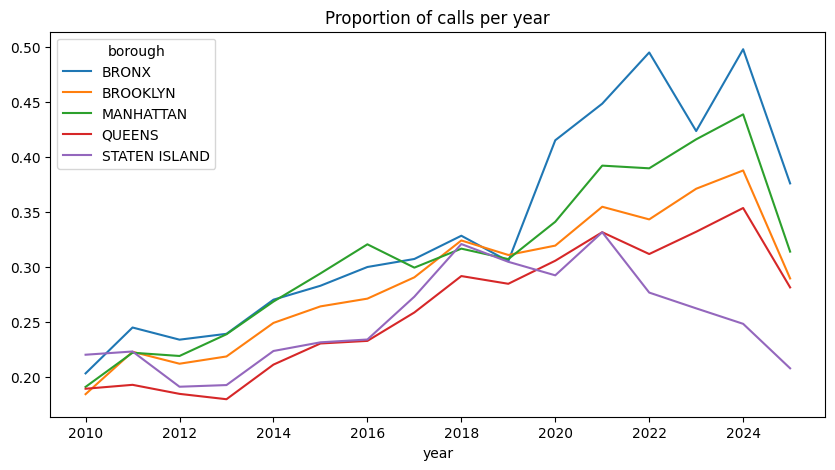

In [42]:
complaint_ts = requests_db.get_complaint_time_series()
complaint_ts.pivot_table(index='year',columns='borough', values='complaints_per_capita').plot(figsize=(10,5), title='Proportion of calls per year');

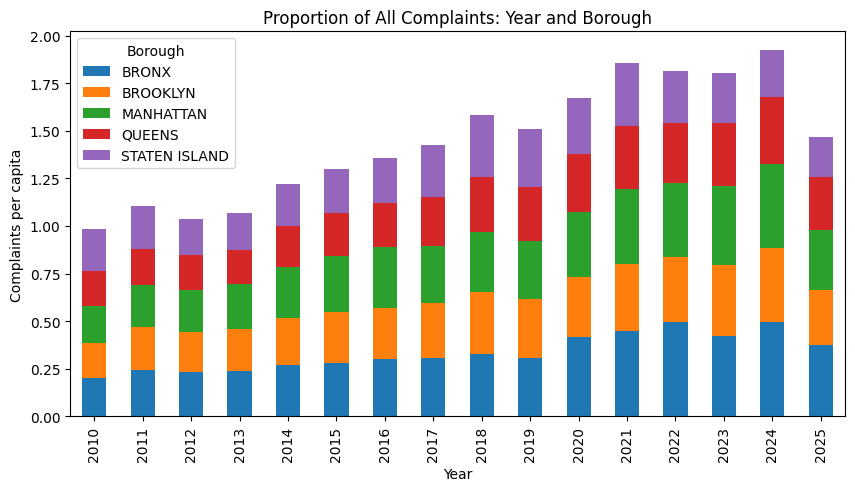

In [43]:
pivot = complaint_ts.pivot(index="year", columns="borough", values="complaints_per_capita")

ax = pivot.plot(kind="bar", stacked=True, figsize=(10, 5))

ax.set_ylabel("Complaints per capita")
ax.set_xlabel("Year")
ax.set_title("Proportion of All Complaints: Year and Borough")
ax.legend(title="Borough");


### Density map of complaints
- This density map gives a high level view of the concentration of 311 calls
- There are many calls across the entire city, but Staten Island is relatively lower whereas the Bronx and Manhattan have more calls

In [47]:
lat_long_data = requests_db.connection.execute('SELECT latitude, longitude FROM nyc311;').df()
lat_long_data = lat_long_data[lat_long_data.latitude > 1]

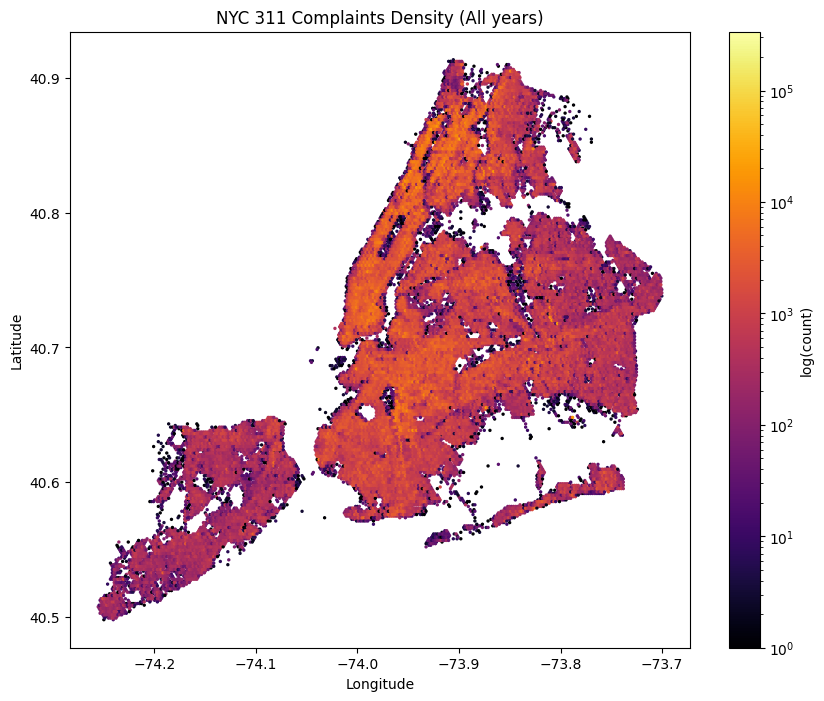

In [48]:
plt.figure(figsize=(10,8))
plt.hexbin(lat_long_data["longitude"], lat_long_data["latitude"], gridsize=300, cmap="inferno", bins="log")
plt.colorbar(label="log(count)")
plt.title("NYC 311 Complaints Density (All years)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<h1 style="background-color:#d1cfcf;padding-top:20px;padding-bottom:20px;padding-left:5px">EDA - the Bronx + noise complaints</h1>
This following section focuses more specifically on the Bronx as it is the borough with the most complaints per person.

### 1. Noise complaints over time
- The complaint count seems to follow a cyclical pattern, my assumption is that there are peaks during the summer
- Noise complaints have also been increasing over time, which aligns with the general increase in calls across the city

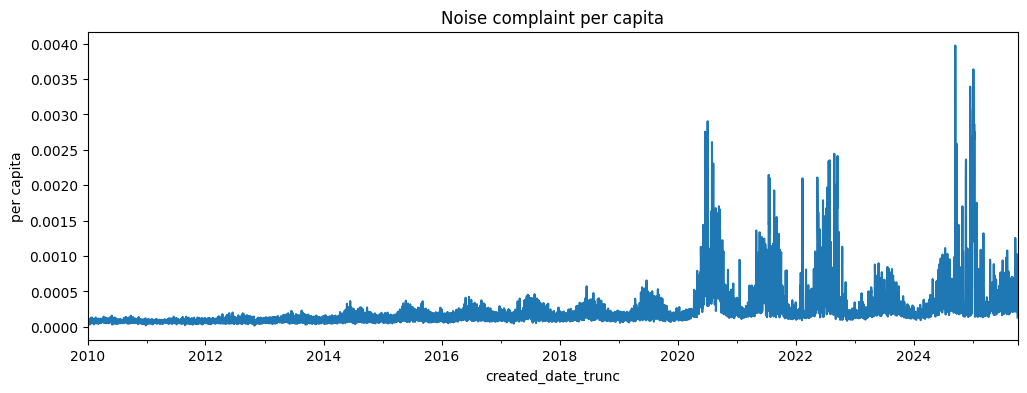

In [49]:
noise_ts_year_month_all = requests_db.get_bronx_timeseries()
noise_ts_year_month_all.set_index('created_date_trunc').sort_index()['complaints_per_capita'].plot(kind='line', title='Noise complaint per capita', ylabel='per capita', figsize=(12,4));



### 2. Identify anomalies 
- In order to see where these spikes happen, we can calculate a Z-score and see which values fall two standard deviations outside the mean (these are anomalies)
- Finding patterns with anomalies aids in the feature selection process
- This detection process sees that the weekends (days 5 and 6 <--> Sat and Sun) account for the vast majority of anomalies

In [50]:
noise_ts_year_month_all.loc[:, 'day_of_week'] = noise_ts_year_month_all['created_date_trunc'].dt.dayofweek
noise_ts_year_month_all['year'] = noise_ts_year_month_all['created_date_trunc'].dt.year
noise_ts_year_month_all['zscore'] = noise_ts_year_month_all.groupby('year')['complaints_per_capita'].transform(lambda x: zscore(x))
anomalies = noise_ts_year_month_all[noise_ts_year_month_all['zscore'] > 2].copy()

noise_ts_year_month_all['weekend'] = noise_ts_year_month_all['day_of_week'].isin([5,6])

In [51]:
(anomalies.day_of_week.value_counts() / anomalies.day_of_week.value_counts().sum()).rename('proportion_of_requests').to_frame()

,proportion_of_requests
day_of_week,
6,0.481366
5,0.335404
0,0.077640
1,0.037267
4,0.027950
3,0.021739
2,0.018634


### 2. Impact of seasons:
- Assume that summers are June, July, August, and September
- Logically, summers are busy times so there could be more noise complaints
- When calculating how many of the 311 calls occur in the summer, we see that they account for 46% of the total complaints
- This indicates that a flag identifying summer or not summer could be a useful feature

In [52]:
noise_ts_year_month_all['month'] = noise_ts_year_month_all['created_date_trunc'].dt.month
noise_ts_year_month_all['summer'] = noise_ts_year_month_all['month'].isin([6,7,8,9])

In [53]:
(noise_ts_year_month_all.groupby('month')[['complaint_count']].sum() / noise_ts_year_month_all.groupby('month')[['complaint_count']].sum().sum()).rename(columns={'proportion_of_requests':'proportion_of_requests'}).sort_values(by='complaint_count',ascending=False)


,complaint_count
month,
7,0.122919
9,0.116226
8,0.110328
6,0.106803
5,0.102142
1,0.074077
10,0.072290
4,0.067293
12,0.060272


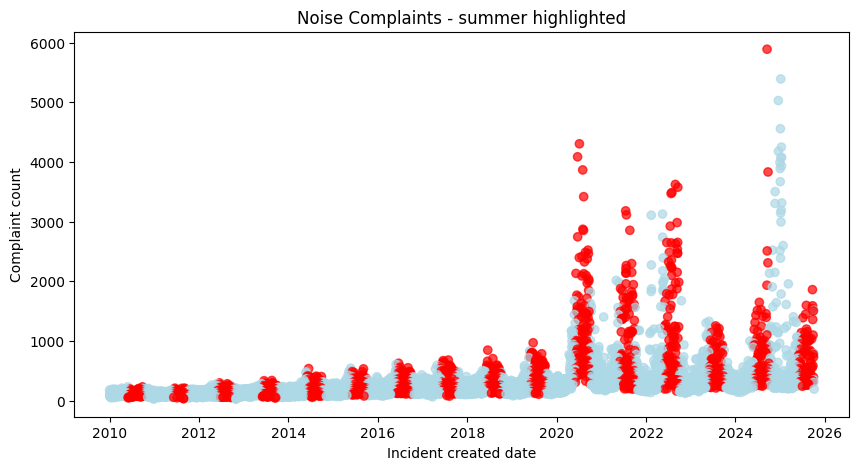

In [54]:
plt.figure(figsize=(10,5))
plt.scatter(noise_ts_year_month_all['created_date_trunc'], 
    noise_ts_year_month_all['complaint_count'],
    c=noise_ts_year_month_all['summer'].map({True: 'red', False: 'lightblue'}),
    alpha=0.7
)
plt.title("Noise Complaints - summer highlighted")
plt.xlabel("Incident created date")
plt.ylabel("Complaint count")
plt.show()

### 3. Time of day
- Another hypothesis is that there might be more noise complaints at night, as people tend to take more issue with noise at night
- This is confimed to be the case, as 73.5% of calls occur at night

In [55]:
noise_ts_granular = requests_db.get_bronx_ts_granular()

In [56]:
def categorical_time_of_day(hour):
    if 4 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    else:
        return 'night'

noise_ts_granular['time_of_day'] = noise_ts_granular['created_date_trunc'].dt.hour.apply(categorical_time_of_day)

In [57]:
noise_ts_granular.groupby('time_of_day')[['complaint_count']].sum().sort_values(by='complaint_count',ascending=False) / noise_ts_granular.groupby('time_of_day')[['complaint_count']].sum().sort_values(by='complaint_count',ascending=False).sum()

,complaint_count
time_of_day,
night,0.742414
morning,0.132960
afternoon,0.124626


In [58]:
requests_db.connection.execute("""
EXPORT DATABASE 'nyc311_snapshot' (FORMAT PARQUET);
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### 4. Lag
- Do previous days inform future days?
- The ACF plot below shows that the correlation spikes in a cyclical pattern (7 days)
- A 1 day lag is also significant in terms of correlation
- Including a lag feature could be useful as well since we see this pattern

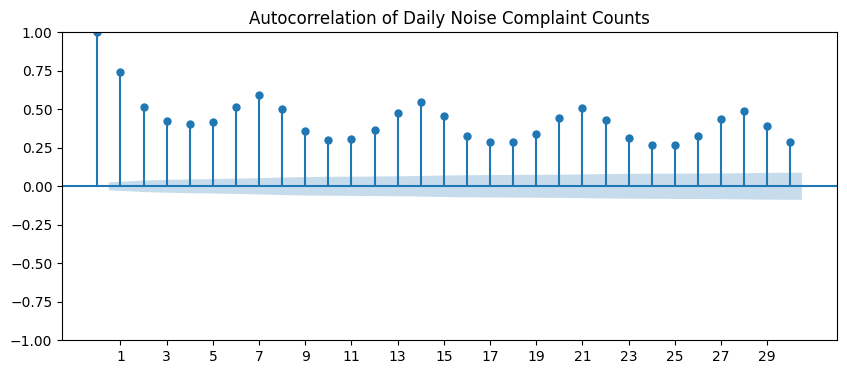

In [64]:
autocorr = noise_ts_year_month_all.set_index('created_date_trunc').sort_index()[['complaint_count']]

fig, axes = plt.subplots(1, 1, figsize=(10, 4))
plot_acf(autocorr.dropna(), lags=30, ax=axes)
axes.set_title("Autocorrelation of Daily Noise Complaint Counts")
axes.set_xticks(np.arange(1,31,2))
plt.show();

<h1 style="background-color:#d1cfcf;padding-top:20px;padding-bottom:20px;padding-left:5px">Predictive Model</h1>


- This is a logistic regression model which predicts periods with a significant noise complaint call volume. 
- "Significant" is defined as having a count in the 70th percentile in order to capture a meaningful number of days as significant
  - The threshold is calculated on a per year basis because the overall averages change over time
- Based on the previous data exploration, the features are:
  - Summer (1 or 0)
  - Weekend (1 or 0)
  - Time of day (morning, afternoon, evening) - one hot encoded
  - Count of complaints - 7 day lag
  

In [65]:
model_data = classification_model.set_up_features(noise_ts_granular, noise_ts_year_month_all)

In [66]:
model_data = classification_model.define_classes(model_data)

In [67]:
model_data.high_complaint_period.value_counts()

high_complaint_period
0    94560
1    37197
Name: count, dtype: int64

#### Create training and test set
- The training and test set is divided based on time since this is a time series set (so we cannot shuffle randomly)

In [68]:
x_train, x_test, y_train, y_test = classification_model.get_train_and_test_data(model_data)

Loading model and data from pickle


#### Ensure there are enough values for each class (high complaint period vs. normal)
- High complaint periods are not very common, so we need to make sure the samples consider both classes

In [69]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

high_complaint_period
0    0.725765
1    0.274235
Name: proportion, dtype: float64
high_complaint_period
0    0.698721
1    0.301279
Name: proportion, dtype: float64


### Model results:
- After fitting the model, I find the optimal probability threshold
- This value is determined by finding the threshold which produces the best precision and recall values
- This threshold is around 0.38
- The precision is 0.61 and the recall is 0.78
  - The recall is quite good, but the lower precision indicates that the model over classifies high complaint periods
  - I would argue that over classification in this sense is not harmful, as there will likely still be noise complaints that can be dealt with on those days. However, this could not be the most optimal use of resources

In [70]:
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_probs = model.predict_proba(x_test)[:, 1]

In [71]:
model, y_pred, y_probs = classification_model.fit_model_and_predict(x_train, y_train, x_test)

Loading model and data from pickle


In [72]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1 = (2 * precision * recall) / (precision + recall)
best_thresh_index = f1.argmax()
best_threshold = thresholds[best_thresh_index]  
print(f"The best threshold is ---> {round(best_threshold, 5)}")
print(f"precision = {round(precision[best_thresh_index], 2)}")
print(f"recall = {round(recall[best_thresh_index], 2)}")


y_pred = (y_probs >= best_threshold).astype(int)
print(classification_report(y_test, y_pred))

The best threshold is ---> 0.38231
precision = 0.61
recall = 0.78
              precision    recall  f1-score   support

           0       0.89      0.79      0.84     27582
           1       0.61      0.78      0.69     11893

    accuracy                           0.79     39475
   macro avg       0.75      0.78      0.76     39475
weighted avg       0.81      0.79      0.79     39475



#### Confusion matrix
- The matrix below shows that the model does a good job of identifying high complaint days which were actually considered to have significant call volume 

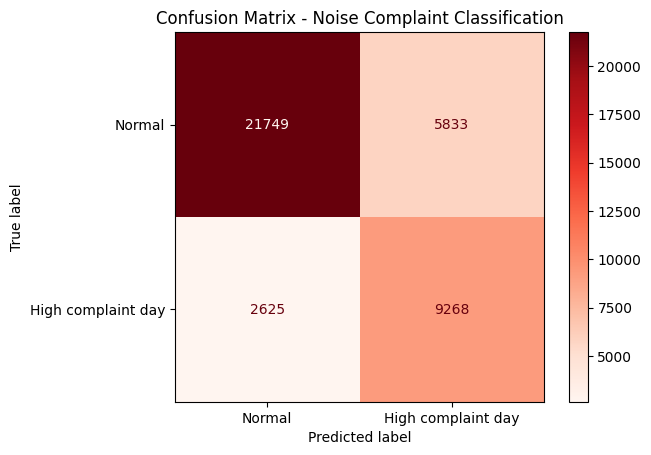

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'High complaint day'])
disp.plot(cmap='Reds')
plt.title("Confusion Matrix - Noise Complaint Classification")
plt.show()

#### Precision / recall curve
- The below graph shows how the precision and recall change for the various threshold values
- Recall decreases significantly the higher the threshold is 

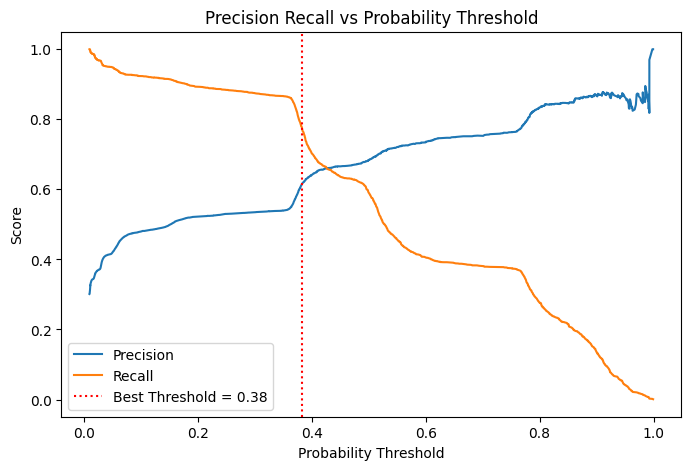

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision Recall vs Probability Threshold")
plt.show()

#### ROC curve
- The Receiver Operating Characteristic (ROC) curve demonstrates how good the model is at separating normal days from high complaint days
- The AUC (area under the curve) directly represents this idea, as a value of 1 is a perfect classifier.
- A trivial classifier (orange line below) would have an AUC of .50, so our model at least performs better than a trivial model


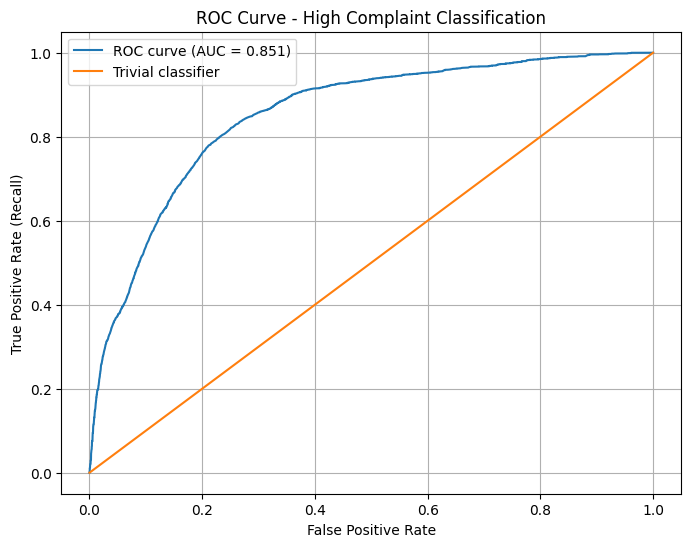

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

 
false_pos, true_pos, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(false_pos, true_pos, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], label='Trivial classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - High Complaint Classification")
plt.legend()
plt.grid(True)
plt.show()

#### Feature importance
- We can examine the coefficients to see how important the features are
- The coefficients are the log odds in a logistic regression
- A coefficient large in magnitude means it has a more significant impact
- A positive coefficient means that the feature increases the likelihood of a high complaint day
- We can see that nighttime, weekends, and summer all have a positive effect on high complaint days

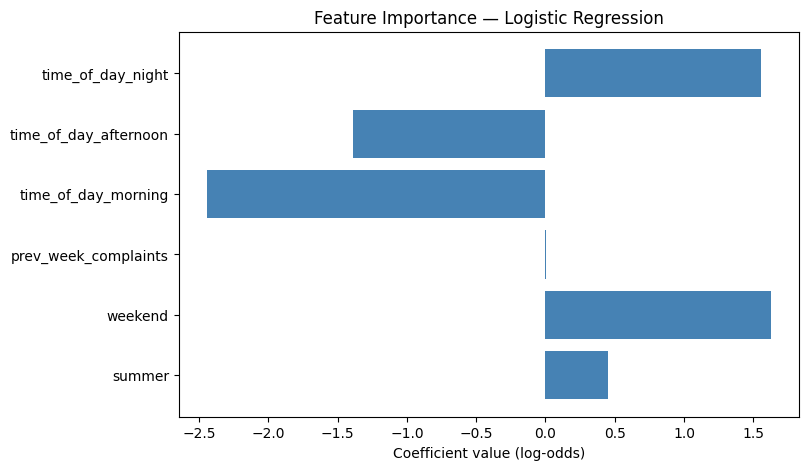

In [76]:
feature_names = x_test.columns
coefficients = model.coef_[0]

importance_df = pd.DataFrame({ "feature": feature_names, "coefficient": coefficients})

plt.figure(figsize=(8, 5))
plt.barh(importance_df["feature"], importance_df["coefficient"], color="steelblue")
plt.xlabel("Coefficient value (log-odds)")
plt.title("Feature Importance — Logistic Regression");


### Save model to pickle
- The below code saves the model and input data so that it does not need to be re-run 

In [77]:
import pickle

model_pickle = {
    "model": model, 
    "x_data": [x_train, x_test],
    "y_data": [y_train, y_test, y_pred],
    "features": list(x_test.columns),  
    "threshold_used": best_threshold,             
    "results": {
        "roc_auc": roc_auc_score(y_test, y_probs),
        "classification_report": classification_report(y_test, (y_probs >= best_threshold).astype(int), zero_division=0, output_dict=True)
    }
}

from pathlib import Path

file_path = Path("model_pickle.pkl")

if file_path.exists():
    print('Model pickle already exists')
else:
    print("Saving model pickle")
    with open("model_pickle.pkl", "wb") as f:
        pickle.dump(model_pickle, f)

Model pickle already exists
